In [21]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Documents/REx Lab/TinyMPC/julia/altro_rocket/Project.toml`


In [22]:
using LinearAlgebra
using StaticArrays
using Printf
using Altro
using RobotDynamics
const RD = RobotDynamics
using TrajectoryOptimization
const TO = TrajectoryOptimization
using Plots
using ForwardDiff  # needed for @autodiff
using FiniteDiff   # needed for @autodiff
import RobotDynamics: AbstractModel
using RobotDynamics: @autodiff

In [23]:
## ---------------------ROCKET LANDING--------
#Define a Discrete Dynamics model using RobotDynamics.jl
@autodiff struct Rocket <: RobotDynamics.DiscreteDynamics end

RD.state_dim(::Rocket) = 6
RD.control_dim(::Rocket) = 3

#RK4 integrator with free time and slack controls 
function RD.discrete_dynamics!(model::Rocket, x_next, x, u, t, h)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0;  
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    x_next .= A*x + B*u + f*0
    return nothing     
end
function RD.discrete_dynamics(model::Rocket, x, u, t, h)
    
    #T makes x_next the dual variable type in order to use ForwardDiff
    T = promote_type(eltype(x), eltype(u))
    x_next = zeros(T, size(x, 1))
    RD.discrete_dynamics!(model::Rocket, x_next, x, u, t, h)
    return x_next
end
#redefine the copy function to work with discrete dynamics
function Base.copy(model::Rocket)
    return Rocket()
end

In [24]:
#Create the RobotDynamics model
model = Rocket()

#obtain the size of the model (states, controls)
nx, nu = size(model)
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
tf = (N-1)*dt
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Qk = 10e-1
Rk = 1e-0
Qfk = 100

Q = Diagonal(@SVector fill(Float64(Qk), nx))
R = Diagonal(@SVector fill(Float64(Rk), nu))
Qf = Diagonal(@SVector fill(Float64(Qfk), nx))
obj = LQRObjective(Q,R,Qf,xg,N)

# CONSTRAINT
cons = ConstraintList(nx,nu,N)

ncx = 2*nx*1
ncu = 2*nu*1
ncg = 1

if ncg > 0
    add_constraint!(cons, GoalConstraint(xg), N)
end
if ncu > 0
    u_min = -10.0*ones(nu)
    u_max =  105.0*ones(nu)
    bnd = BoundConstraint(nx, nu, u_min=u_min, u_max=u_max)
    add_constraint!(cons, bnd, 1:N-1)
end
if ncx > 0
    # state is x y v θ
    x_min = [-5,-5,0,-10,-10,-10.0]
    x_max = [5,5,20,10,10,10.0]
    bnd1 = BoundConstraint(nx, nu, x_min=x_min, x_max=x_max)
    add_constraint!(cons, bnd1, 1:N)
end

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [[0;0;100.0] for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

# SOLVE
prob = Problem(model, obj, x0, tf, xf=xg, constraints=cons, N=N, U0=U)

# initial_controls!(prob, U)
# rollout!(prob);

solver = ALTROSolver(prob)
set_options!(solver, 
    constraint_tolerance = 1e-6,
    cost_tolerance = 1e-2,
    cost_tolerance_intermediate = 1e-1,
    gradient_tolerance = 10.0,
    gradient_tolerance_intermediate = 1.0,

    # expected_decrease_tolerance = 1e-2,
    # iterations_inner = 1,
    # dJ_counter_limit = 10,
    # square_root = false,
    # line_search_lower_bound = 1e-8,
    # line_search_upper_bound = 10.0,
    # line_search_decrease_factor = 0.5,
    # iterations_linesearch = 10,
    # max_cost_value = 1.0e8,
    # max_state_value = 1.0e8,
    # max_control_value = 1.0e8,
    # static_bp = true,
    # save_S = false,
    # closed_loop_initial_rollout = false,

    # bp_reg = false,
    # bp_reg_initial = 0.0,
    # bp_reg_increase_factor = 1.6,
    # bp_reg_max = 1.0e8,
    # bp_reg_min = 1.0e-8,
    # bp_reg_type = :control,
    # bp_reg_fp = 10.0,

    # use_conic_cost = false,
    # penalty_initial = 1.0,
    # penalty_scaling = 10.0,
    # penalty_max = 1e8,
    # dual_max = 1e8,
    # active_set_tolerance_al = 1e-3,
    # iterations_outer = 30,
    # kickout_max_penalty = false,
    # reset_duals= true,
    # reset_penalties = true,

    # force_pn = false,
    # verbose_pn = false,
    # n_steps = 2,
    # solve_type = :feasible,
    # projected_newton_tolerance = 1e-3,
    # active_set_tolerance_pn = 1e-3,
    # multiplier_projection = true,
    # ρ_chol = 1e-2,     # cholesky factorization regularization
    # ρ_primal = 1.0e-8, # primal regularization
    # ρ_dual = 1.0e-8,   # regularization for multiplier projection 
    # r_threshold = 1.1,    

    projected_newton = false,
#     reuse_jacobians = false,
#     trim_stats = true,  # disable if you want to call methods after solve that add to history
#     iterations = 1000,   # max number of iterations
#     show_summary = true, 
    verbose = 3)

set_options!(solver, projected_newton=false, verbose=3)
solve!(solver);
X_altro = states(solver)
U_altro = controls(solver);

iter  AL iter iLQR iter cost      ||v||     expected  dJ        grad      z         α         ρ         info                                    
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
1                       28068.065 5.93e+00  1.28e+08  1.28e+08  3.09e+02  1.00      1.00e+00  1.00e-08                                          


2                       15245.885 1.28e+00  1.29e+04  1.28e+04  2.18e+00  0.99      1.00e+00  1.00e-08                                          


3                       15218.299 8.73e-01  2.75e+01  2.76e+01  9.44e-02  1.00      1.00e+00  1.00e-08                                          


4                       15218.298 8.71e-01  1.16e-03  1.16e-03  2.50e-04  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                 


5     1                 15310.371 2.37e-01  2.62e+02  2.62e+02  3.86e-01  1.00      1.00e+00  1.00e-08                                          


iter  AL iter iLQR iter cost      ||v||     expected  dJ        grad      z         α         ρ         info                                                                                        
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
6     1                 15310.371 2.37e-01  1.24e-26  0.00e+00  1.19e-15  Inf       0.00e+00  1.60e-08  No step. Expected decrease too small. Cost criteria satisfied                               


7     2                 15337.510 1.55e-01  1.34e+02  1.34e+02  2.75e-01  1.00      1.00e+00  1.00e-08                                                                                              


8     2                 15337.510 1.55e-01  8.51e-27  0.00e+00  9.95e-16  Inf       0.00e+00  1.60e-08  No step. Expected decrease too small. Cost criteria satisfied                               


9     3                 15349.045 7.28e-02  4.24e+01  4.24e+01  1.76e-01  1.00      1.00e+00  1.00e-08                                                                                              


10    3                 15349.030 7.28e-02  1.49e-02  1.51e-02  3.73e-03  1.01      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


11    4                 15354.151 6.81e-03  3.97e+01  3.97e+01  1.43e-01  1.00      1.00e+00  1.00e-08                                                                                              


12    4                 15354.149 6.81e-03  1.12e-03  1.13e-03  9.04e-04  1.01      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


13    5                 15353.772 5.78e-04  5.00e+00  5.00e+00  3.57e-02  1.00      1.00e+00  1.00e-08                                                                                              


14    5                 15353.771 5.78e-04  7.52e-04  7.60e-04  5.32e-04  1.01      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


15    6                 15353.289 1.61e-04  8.76e-01  8.76e-01  1.07e-02  1.00      1.00e+00  1.00e-08                                                                                              


iter  AL iter iLQR iter cost      ||v||     expected  dJ        grad      z         α         ρ         info                                                                                        
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
16    6                 15353.289 1.61e-04  6.12e-05  6.25e-05  9.21e-05  1.02      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


17    7                 15352.891 4.82e-05  5.42e-01  5.41e-01  6.96e-03  1.00      1.00e+00  1.00e-08                                                                                              


18    7                 15352.891 4.82e-05  3.90e-04  3.94e-04  1.49e-04  1.01      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


19    8                 15352.740 1.79e-05  2.21e-01  2.21e-01  3.01e-03  1.00      1.00e+00  1.00e-08                                                                                              


20    8                 15352.740 1.79e-05  6.56e-05  6.56e-05  2.82e-05  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


21    9                 15352.342 2.68e-05  4.51e-01  3.86e-01  6.25e-03  0.86      1.00e+00  1.00e-08                                                                                              


22    9                 15352.287 1.17e-05  5.52e-02  5.52e-02  8.09e-04  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


23    10                15352.011 1.16e-05  2.94e-01  2.94e-01  5.11e-03  1.00      1.00e+00  1.00e-08                                                                                              


24    10                15352.011 1.16e-05  3.11e-11  0.00e+00  1.59e-08  Inf       0.00e+00  1.60e-08  No step. Expected decrease too small. Cost criteria satisfied                               


25    11                15351.822 2.21e-05  2.47e-01  2.03e-01  4.86e-03  0.82      1.00e+00  1.00e-08                                                                                              


iter  AL iter iLQR iter cost      ||v||     expected  dJ        grad      z         α         ρ         info                                                                                        
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
26    11                15351.785 1.04e-05  3.69e-02  3.69e-02  6.82e-04  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


27    12                15351.604 9.21e-06  1.92e-01  1.92e-01  4.35e-03  1.00      1.00e+00  1.00e-08                                                                                              


28    12                15351.604 9.21e-06  4.94e-09  4.95e-09  2.83e-07  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


29    13                15351.490 1.72e-05  1.51e-01  1.24e-01  4.01e-03  0.82      1.00e+00  1.00e-08                                                                                              


30    13                15351.467 8.10e-06  2.24e-02  2.24e-02  5.48e-04  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


31    14                15351.365 6.98e-06  1.11e-01  1.11e-01  3.49e-03  1.00      1.00e+00  1.00e-08                                                                                              


32    14                15351.365 6.98e-06  1.35e-06  1.35e-06  3.54e-06  1.00      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


33    15                15351.305 1.25e-05  8.09e-02  6.71e-02  3.11e-03  0.83      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     


34    16                15351.235 4.85e-07  1.07e-01  1.07e-01  3.00e-03  1.00      1.00e+00  1.00e-08                                                                                              


35    16                15351.235 2.16e-07  7.61e-06  7.90e-06  7.82e-06  1.04      1.00e+00  1.00e-08  Cost criteria satisfied                                                                     



SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 35
    Solve Time: 176.070592 (ms)

  Covergence
    Terminal Cost: 15351.234783342306
    Terminal dJ: 7.902215656940825e-6
    Terminal gradient: 7.820578388776682e-6
    Terminal constraint violation: 2.1610287370015746e-7
    Solve Status: SOLVE_SUCCEEDED


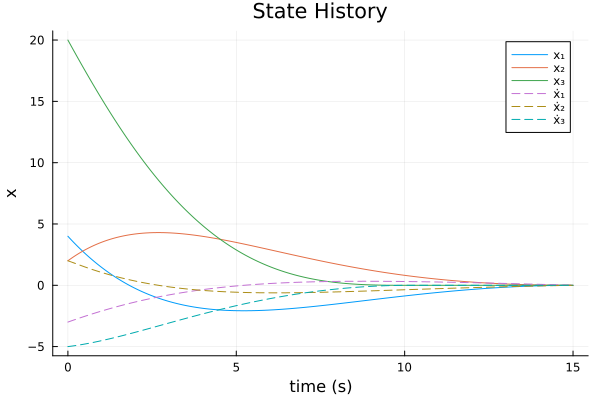

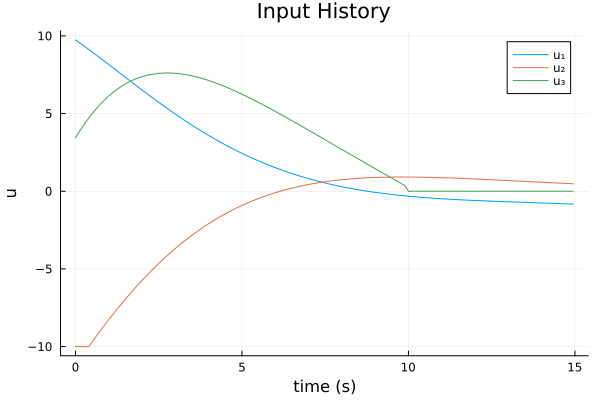

In [25]:
Un = hcat(Vector.(U_altro)...)
Xn = hcat(Vector.(X_altro)...)
display(plot(t_vec,Xn',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Un',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))